In [1]:
import drjit as dr
import mitsuba as mi
import numpy as np
from scenes import cornell_box, cornell_box_steady_state
import matplotlib.pyplot as plt
from IPython.display import HTML


mi.set_variant('cuda_ad_rgb')

import mitransient as mitr

In [2]:
class GaussianPulse:
    """
    Normalized Gaussian pulse centered at t=0.

    The pulse is defined as:
        p(t) = (1 / (σ √(2π))) × exp(-t² / (2σ²))

    where σ is the standard deviation (width_opl in optical path length units).
    """

    def __init__(self, width_opl: float):
        """
        Initialize the Gaussian pulse.

        Args:
            width_opl: Standard deviation in optical path length units (meters)
        """
        self.width_opl = width_opl
        self.normalization = 1.0 / (self.width_opl * dr.sqrt(2 * dr.pi))

    def eval(self, t: mi.Float) -> mi.Float:
        """
        Evaluate the Gaussian at time offset t.

        Args:
            t: Time offset from pulse center (in OPL units)

        Returns:
            Normalized Gaussian value at t
        """
        return self.normalization * dr.exp(-0.5 * (t / self.width_opl) ** 2)

    def sample(self, xi: mi.Float):
        """
        Sample a time offset from the Gaussian distribution using inverse CDF.

        Args:
            xi: Uniform random value in [0, 1]

        Returns:
            Tuple of (sampled_time, weight) where weight is always 1.0
            for importance sampling
        """
        # TODO: Implement inverse CDF sampling using the inverse error function
        # Hint: For a Gaussian, the inverse CDF is: μ + σ × √2 × erfinv(2ξ - 1)
        # Use dr.erfinv() for the inverse error function
        return self.width_opl * dr.sqrt(2) * dr.erfinv(2 * xi - 1)

    

In [3]:
# Test that the pulse integrates to 1
pulse = GaussianPulse(width_opl=0.05)
t = dr.linspace(mi.Float, -0.5, 0.5, 1000)
dt = 1.0 / 1000
integral = dr.sum(pulse.eval(t)) * dt
print(f"Integral: {integral[0]:.4f} (should be ~1.0)")

# Test sampling
samples = [pulse.sample(dr.opaque(mi.Float, np.random.random()))[0] for _ in range(10000)]
print(f"Sample mean: {np.mean(samples):.4f} (should be ~0.0)")
print(f"Sample std: {np.std(samples):.4f} (should be ~{pulse.width_opl:.4f})")

Integral: 0.9990 (should be ~1.0)
Sample mean: -0.0003 (should be ~0.0)
Sample std: 0.0499 (should be ~0.0500)


In [4]:
class SimpleIntegrator(mi.SamplingIntegrator):
    def __init__(self, sample_lights = True, sample_bsdf=True, max_depth=5, props=mi.Properties()):
        super().__init__(props)
        self.sample_lights = sample_lights
        self.sample_bsdf = sample_bsdf
        self.max_depth = max_depth

    def sample(self, scene, sampler, ray, medium=None, active=True):
        # Intersect ray with scene
        beta = mi.Color3f(1.0)
        result = mi.Color3f(0.0)
        specular = dr.auto.ad.Bool(True)
        
        for depth in range(self.max_depth):
            si = scene.ray_intersect(ray, active)

            active &= si.is_valid()

            if not dr.any(active):
                # Add environment contribution for rays that didn't hit anything
                env_mask = active & (specular | ~dr.auto.ad.Bool(self.sample_lights))
                result[env_mask] += beta * scene.environment().eval(si, env_mask)
                break

            # Add emitter contribution if we hit a light and either sampling specular or not sampling lights
            emitter_mask = active & (specular | ~dr.auto.ad.Bool(self.sample_lights))
            result[emitter_mask] += beta * si.emitter(scene).eval(si, emitter_mask)

            # Sample direct illumination from light sources
            ctx = mi.BSDFContext()
            bsdf = si.bsdf()

            if self.sample_lights:
                # Sample a light source
                ds, emitter_weight = scene.sample_emitter_direction(
                    si, sampler.next_2d(), True, active
                )

                active_light = active & (ds.pdf > 0)

                if dr.any(active_light):
                    # Evaluate BSDF
                    bsdf_val = bsdf.eval(ctx, si, si.to_local(ds.d), active_light)

                    # Visibility test
                    ray_shadow = si.spawn_ray_to(ds.p)
                    visible = ~scene.ray_test(ray_shadow, active_light)

                    # Accumulate contribution
                    result[active_light & visible] += (
                        beta * bsdf_val * emitter_weight
                    )
            
            # Sample BSDF to get new direction
            if (self.sample_bsdf):
                bsdf_sample, bsdf_weight = bsdf.sample(
                    ctx, si, sampler.next_1d(), sampler.next_2d(), active
                )

                active_bsdf = active & dr.any(bsdf_weight != 0)

                # Update beta with mask
                beta[active_bsdf] = beta * bsdf_weight

                # Spawn new ray with mask
                ray[active_bsdf] = si.spawn_ray(si.to_world(bsdf_sample.wo))

                # Update specular flag with mask
                specular[active_bsdf] = mi.has_flag(bsdf_sample.sampled_type, mi.BSDFFlags.Delta)
                
                # Update active mask - continue only where BSDF sampling succeeded
                active &= active_bsdf
            else:
                # uniformly sample hemisphere
                wi = sampler.next_2d()
                local_dir = mi.warp.square_to_uniform_hemisphere(wi)
                bsdf_val = bsdf.eval(ctx, si, local_dir, active)
                pdf = mi.warp.square_to_uniform_hemisphere_pdf(local_dir)
                bsdf_weight = bsdf_val * dr.abs(dr.dot(si.n, si.to_world(local_dir))) / pdf
                
                # Update with mask
                beta[active] = beta * bsdf_weight
                ray[active] = si.spawn_ray(si.to_world(local_dir))
                specular[active] = dr.auto.Bool(False)

        return result, active, []

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def visualize_transient(transient_data, start_opl, bin_width_opl):
    """Create an animation of light propagating through the scene."""
    data = np.array(transient_data)
    print(f"Data shape: {data.shape}")  # Should be (H, W, 3, T)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')
    
    # Normalize data
    vmax = np.percentile(data, 99)
    
    # Get first RGB frame: shape (H, W, 3)
    first_frame = np.clip(data[:, :, :, 0], 0, vmax) / vmax
    im = ax.imshow(first_frame)
    
    # Create title as text object for proper blitting
    title = ax.text(0.5, 1.05, '', transform=ax.transAxes, 
                    ha='center', fontsize=12)

    def update(frame):
        # Get RGB frame at time index 'frame': shape (H, W, 3)
        frame_data = np.clip(data[:, :, :, frame], 0, vmax) / vmax
        im.set_array(frame_data)
        opl = start_opl + frame * bin_width_opl
        t_ns = opl / 0.3  # Convert to nanoseconds (c ≈ 0.3 m/ns)
        title.set_text(f'Frame {frame}/{data.shape[3]-1} | t = {t_ns:.2f} ns (OPL = {opl:.2f} m)')
        return [im, title]

    # Number of frames is the last dimension (temporal bins)
    num_frames = data.shape[3]
    print(f"Creating animation with {num_frames} frames")
    
    anim = FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)
    return anim

def plot_pixel_transient(transient_data, x, y, start_opl, bin_width_opl):
    """Plot temporal response at a single pixel."""
    data = np.array(transient_data)
    
    # data shape is (H, W, 3, T), get pixel at (y, x) across all time
    response = data[y, x, :, :]  # Shape: (3, T)
    # Convert to luminance
    luminance = 0.2126 * response[0] + 0.7152 * response[1] + 0.0722 * response[2]

    times = start_opl + np.arange(luminance.shape[0]) * bin_width_opl
    times_ns = times / 0.3

    plt.figure(figsize=(10, 6))
    plt.plot(times_ns, response[0], 'r-', alpha=0.7, label='Red')
    plt.plot(times_ns, response[1], 'g-', alpha=0.7, label='Green')
    plt.plot(times_ns, response[2], 'b-', alpha=0.7, label='Blue')
    plt.plot(times_ns, luminance, 'k-', linewidth=2, label='Luminance')
    plt.xlabel('Time (ns)')
    plt.ylabel('Intensity')
    plt.title(f'Transient at pixel ({x}, {y})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [6]:
class TimeGatedTransientPath(mi.SamplingIntegrator):
    def __init__(self, props=mi.Properties()):
        super().__init__(props)
        self.max_depth = props.get('max_depth', 8)
        self.pulse = GaussianPulse(width_opl=props.get('gaussian_stddev', 0.03))
        self.camera_unwarp = props.get('camera_unwarp', False)
        self.temporal_filter = props.get('temporal_filter', 'box')

    @dr.syntax
    def sample(self, scene, sampler, ray, target_time, medium=None, active=True):
        """
        Sample paths and weight by temporal pulse.

        Args:
            scene: The scene to render
            sampler: Random number generator
            ray: Camera ray
            target_time: The target time (in OPL units) we're rendering for
            medium: Participating medium (optional)
            active: Active ray mask

        Returns:
            (color, valid, aov) tuple
        """
        result = mi.Color3f(0.0)
        throughput = mi.Color3f(1.0)
        ray = mi.Ray3f(ray)
        active = mi.Bool(active)

        # Track total path length (optical path length)
        path_length = mi.Float(0.0)
        depth = mi.UInt32(0)

        while dr.hint(active, max_iterations=self.max_depth, label="Path"):
            si = scene.ray_intersect(ray, active)
            active &= si.is_valid()

            # Accumulate path length
            path_length[active] += si.t

            # Get BSDF and context
            ctx = mi.BSDFContext()
            bsdf = si.bsdf()

            # Emitter contribution (only for directly hit emitters)
            emitter = si.emitter(scene)
            emitter_contrib = dr.select(
                emitter != None,
                emitter.eval(si, active),
                mi.Color3f(0.0)
            )
            result[active] += throughput * emitter_contrib

            # Sample direct illumination from light sources (NEE)
            ds, emitter_weight = scene.sample_emitter_direction(
                si, sampler.next_2d(), True, active
            )

            active_light = active & (ds.pdf > 0)

            # Remove the if dr.any() check - just use masking
            # Evaluate BSDF
            bsdf_val = bsdf.eval(ctx, si, si.to_local(ds.d), active_light)

            # Visibility test
            ray_shadow = si.spawn_ray_to(ds.p)
            visible = ~scene.ray_test(ray_shadow, active_light)

            # Compute time-gated weight
            distance_to_light = dr.norm(ds.p - si.p)
            total_opl = path_length + distance_to_light
            shifted_time = target_time - total_opl
            pulse_weight = self.pulse.eval(shifted_time)

            # Accumulate contribution (masking handles inactive lanes)
            result[active_light & visible] += (
                throughput * bsdf_val * emitter_weight * pulse_weight
            )

            # Sample BSDF to get new direction
            bsdf_sample, bsdf_weight = bsdf.sample(
                ctx, si, sampler.next_1d(), sampler.next_2d(), active
            )

            active_bsdf = active & dr.any(bsdf_weight != 0)

            # Update throughput with mask
            throughput[active_bsdf] = throughput * bsdf_weight

            # Spawn new ray with mask
            ray[active_bsdf] = si.spawn_ray(si.to_world(bsdf_sample.wo))
            
            # Update depth
            depth[si.is_valid()] += 1
            
            # Update active mask - continue only where BSDF sampling succeeded
            active &= active_bsdf

        return result, mi.Bool(True), []
mi.register_integrator('transient_path', lambda props: TimeGatedTransientPath(props))

In [ ]:
def render_at_time(scene, integrator, target_time, spp=64):
    """Render a single time slice by calling integrator with target_time."""
    sensor = scene.sensors()[0]
    film = sensor.film()
    sampler = sensor.sampler()
    
    film_size = film.crop_size()
    total_sample_count = dr.prod(film_size) * spp
    
    sampler.set_sample_count(spp)
    sampler.seed(0, total_sample_count)
    
    # Generate sample positions
    idx = dr.arange(mi.UInt32, total_sample_count)
    
    # Determine pixel coordinates
    idx_pixel = idx // spp
    pos_x = idx_pixel % film_size[0]
    pos_y = idx_pixel // film_size[0]
    
    # Add sub-pixel jitter
    pixel_center = mi.Vector2f(mi.Float(pos_x), mi.Float(pos_y)) + sampler.next_2d()
    
    # Normalized coordinates [0, 1]
    scale = mi.Vector2f(1.0 / film_size[0], 1.0 / film_size[1])
    normalized_pos = pixel_center * scale
    
    # Sample camera rays
    ray, ray_weight = sensor.sample_ray_differential(
        time=0.0,
        sample1=sampler.next_1d(),
        sample2=normalized_pos,
        sample3=0.0
    )
    
    # Call integrator with target_time
    result, valid, _ = integrator.sample(scene, sampler, ray, target_time)
    
    # Scale by ray_weight
    result = result * ray_weight
    
    # Reshape to (height, width, spp, 3) then average over spp dimension
    result_reshaped = dr.reshape(mi.TensorXf, result, 
                                 shape=(film_size[1], film_size[0], spp, 3))
    
    # Average samples per pixel (mean along axis 2 which is the spp dimension)
    result_image = dr.mean(result_reshaped, axis=2)
    
    return result_image
    
def render_transient(scene, integrator, film_config, spp=64):
    """Render transient by sampling different target times."""
    num_bins = film_config['temporal_bins']
    start_opl = film_config['start_opl']
    bin_width = film_config['bin_width_opl']

    transient_data = []

    for bin_idx in range(num_bins):
        # Target time for this bin (can add jitter for anti-aliasing)
        target_time = start_opl + (bin_idx + 0.5) * bin_width

        print(f"Rendering bin {bin_idx+1}/{num_bins}, target_time={target_time:.3f}")
        
        # Render at this target time
        image = render_at_time(scene, integrator, target_time, spp)
        transient_data.append(np.array(image))

    return np.stack(transient_data, axis=-1)

# Load the transient Cornell Box scene
scene_dict = cornell_box()
scene = mi.load_dict(scene_dict)

# Or use the steady-state version to test your path tracer first
scene_dict_steady = cornell_box_steady_state()
scene_steady = mi.load_dict(scene_dict_steady)
props = mi.Properties()
props['max_depth'] = 5
props['gaussian_stddev'] = 0.03
integrator = TimeGatedTransientPath(props)

# Test with steady-state (all time bins sum together)
# image = render_at_time(scene, integrator, target_time=3.0, spp=128)
# plt.imshow(np.array(image))
# plt.axis('off')
# plt.title('Single time slice at t=3.0m')
# plt.show()
transient_data = render_transient(
    scene, integrator,
    film_config={
        'temporal_bins': 300,
        'start_opl': 3.5,
        'bin_width_opl': 0.02
    },
    spp=128
)  

Rendering bin 1/300, target_time=3.510
Rendering bin 2/300, target_time=3.530
Rendering bin 3/300, target_time=3.550
Rendering bin 4/300, target_time=3.570
Rendering bin 5/300, target_time=3.590
Rendering bin 6/300, target_time=3.610
Rendering bin 7/300, target_time=3.630
Rendering bin 8/300, target_time=3.650
Rendering bin 9/300, target_time=3.670
Rendering bin 10/300, target_time=3.690
Rendering bin 11/300, target_time=3.710
Rendering bin 12/300, target_time=3.730
Rendering bin 13/300, target_time=3.750
Rendering bin 14/300, target_time=3.770
Rendering bin 15/300, target_time=3.790
Rendering bin 16/300, target_time=3.810
Rendering bin 17/300, target_time=3.830
Rendering bin 18/300, target_time=3.850
Rendering bin 19/300, target_time=3.870
Rendering bin 20/300, target_time=3.890
Rendering bin 21/300, target_time=3.910
Rendering bin 22/300, target_time=3.930
Rendering bin 23/300, target_time=3.950
Rendering bin 24/300, target_time=3.970
Rendering bin 25/300, target_time=3.990
Rendering

TypeError: Invalid shape (256, 256, 300) for image data

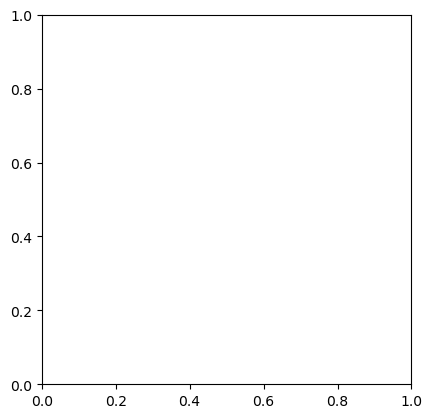

In [13]:
anim = visualize_transient(transient_data, start_opl=3.5, bin_width_opl=0.02)
HTML(anim.to_jshtml())
print(transient_data.shape)

In [8]:
class TransientPath(mi.SamplingIntegrator):
    """
    Transient path tracer that outputs to a TransientHDRFilm.

    Unlike TimeGatedTransientPath which renders a single time slice,
    this integrator adds contributions to all relevant time bins
    based on path length.
    """

    def __init__(self, props=mi.Properties()):
        super().__init__(props)
        self.max_depth = props.get('max_depth', 8)
        pulse_width = props.get('pulse_width_opl', 0.03)
        self.pulse = GaussianPulse(width_opl=pulse_width)

    @dr.syntax
    def sample(self, scene, sampler, ray, medium=None, active=True):
        # Initialize: throughput, path_length, depth, etc.
        result = mi.Color3f(0.0)
        throughput = mi.Color3f(1.0)
        ray = mi.Ray3f(ray)
        active = mi.Bool(active)
        path_length = mi.Float(0.0)
        depth = mi.UInt32(0)

        while dr.hint(active, max_iterations=self.max_depth, label="Transient"):
            # 1. Ray intersection
            si = scene.ray_intersect(ray, active)
            active &= si.is_valid()

            # 2. Accumulate path_length += si.t
            path_length[active] += si.t

            # 3. For NEE contribution:
            #    - Compute total_path_length = path_length + distance_to_light
            ctx = mi.BSDFContext()
            bsdf = si.bsdf()

            # Emitter contribution (only for directly hit emitters)
            emitter = si.emitter(scene)
            emitter_contrib = dr.select(
                emitter != None,
                emitter.eval(si, active),
                mi.Color3f(0.0)
            )
            result[active] += throughput * emitter_contrib

            # Sample direct illumination from light sources (NEE)
            ds, emitter_weight = scene.sample_emitter_direction(
                si, sampler.next_2d(), True, active
            )

            active_light = active & (ds.pdf > 0)

            # Evaluate BSDF
            bsdf_val = bsdf.eval(ctx, si, si.to_local(ds.d), active_light)

            # Visibility test
            ray_shadow = si.spawn_ray_to(ds.p)
            visible = ~scene.ray_test(ray_shadow, active_light)

            # Compute time-gated weight
            distance_to_light = dr.norm(ds.p - si.p)
            total_opl = path_length + distance_to_light
            t_offset = self.pulse.sample(sampler.next_1d())
            effective_opl = total_opl + t_offset

            #    - Sample pulse offset: t_offset = pulse.sample(sampler.next_1d())
            #    - effective_opl = total_path_length + t_offset
            #    - Add contribution to transient film at effective_opl
            pulse_weight = self.pulse.eval(effective_opl)
            
            # 4. BSDF sampling for next bounce

        return result, mi.Bool(True), []

IndentationError: expected an indented block after 'while' statement on line 20 (2160499640.py, line 30)

### AMCW Rendering

In [ ]:
# Phase accumulated along the path
c = 299792458.0  # Speed of light (m/s)
frequency = 1e9  # Example frequency in Hz
omega = 2 * np.pi * frequency  # Angular frequency
phase = omega * (opl / c)

# Phasor components
phasor_real = radiance * dr.cos(phase)
phasor_imag = radiance * dr.sin(phase)